# **Dependencies**

In [2]:
!pip install datasets
!pip install tez
!pip install transformers
!pip install pytorch-lightning
  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 15.4 MB/s 
     |████████████████████████████████| 163 kB 73.1 MB/s 
     |████████████████████████████████| 115 kB 72.0 MB/s 
     |████████████████████████████████| 95 kB 5.6 MB/s 
     |████████████████████████████████| 212 kB 73.4 MB/s 
     |████████████████████████████████| 127 kB 68.1 MB/s 
     |████████████████████████████████| 115 kB 77.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 5.2 MB/s 
     |████████████████████████████████|

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **Libraries**

In [4]:
from datasets import load_dataset

import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader

import tez
import torch
import torch.nn as nn
import transformers
from sklearn import metrics, model_selection, preprocessing
from transformers import AdamW, get_linear_schedule_with_warmup

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


# **Load the dataset and split it into train, valid and test**

In [5]:
_CLASS_NAMES = [
    "admiration",
    "amusement",
    "anger",
    "annoyance",
    "approval",
    "caring",
    "confusion",
    "curiosity",
    "desire",
    "disappointment",
    "disapproval",
    "disgust",
    "embarrassment",
    "excitement",
    "fear",
    "gratitude",
    "grief",
    "joy",
    "love",
    "nervousness",
    "optimism",
    "pride",
    "realization",
    "relief",
    "remorse",
    "sadness",
    "surprise",
    "neutral",
]

mapping = dict(zip(range(len(_CLASS_NAMES)),_CLASS_NAMES))

In [6]:
go_emotions = load_dataset("go_emotions")

data = go_emotions.data

train = go_emotions.data["train"].to_pandas()
valid = go_emotions.data["validation"].to_pandas()
test = go_emotions.data["test"].to_pandas()

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
train.head(10)

,text,labels,id
0,My favourite food is anything I didn't have to cook myself.,[27],eebbqej
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.,[26],edvnz26
6,Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝,[15],ee3b6wu
7,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,"[8, 20]",ef4qmod
8,Damn youtube and outrage drama is super lucrative for reddit,[0],ed8wbdn
9,It might be linked to the trust factor of your friend.,[27],eczgv1o


# **Convert the dataset to a one-hot representation**

In [8]:
n_labels = len(mapping)

def one_hot_labels(df):
    dict_labels = []
    for i in tqdm(range(len(df)), leave=False):
        d = dict(zip(range(n_labels), [0]*n_labels))
        labels = df.loc[i]["labels"]
        for label in labels:
            d[label] = 1
        dict_labels.append(d)
    df_labels = pd.DataFrame(dict_labels)
    return df_labels


In [9]:
train_oh_labels = one_hot_labels(train)
valid_oh_labels = one_hot_labels(valid)
test_oh_labels = one_hot_labels(test)

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

In [10]:
train_oh_labels.shape

(43410, 28)

In [11]:
train = pd.concat([train, train_oh_labels], axis=1)
valid = pd.concat([valid, valid_oh_labels], axis=1)
test = pd.concat([test, test_oh_labels], axis=1)

# **Data Overview**

In [12]:
print(train.shape, valid.shape, test.shape)

(43410, 31) (5426, 31) (5427, 31)


In [37]:
train.head()

,text,labels,id,0,1,2,3,4,5,6,...,18,19,20,21,22,23,24,25,26,27
0,My favourite food is anything I didn't have to cook myself.,[27],eebbqej,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",[27],ed00q6i,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,[14],ed7ypvh,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,[3],ed0bdzj,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
valid.head()

,text,labels,id,0,1,2,3,4,5,6,...,18,19,20,21,22,23,24,25,26,27
0,Is this in New Orleans?? I really feel like this is New Orleans.,[27],edgurhb,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"You know the answer man, you are programmed to capture those codes they send you, don’t avoid them!","[4, 27]",ee84bjg,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,I've never been this sad in my life!,[25],edcu99z,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,"The economy is heavily controlled and subsidized by the government. In any case, I was poking at the lack of nuance in US politics today","[4, 27]",edc32e2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,He could have easily taken a real camera from a legitimate source and change the price in Word/Photoshop and then print it out.,[20],eepig6r,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [39]:
test.head()

,text,labels,id,0,1,2,3,4,5,6,...,18,19,20,21,22,23,24,25,26,27
0,"I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!",[25],eecwqtt,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,It's wonderful because it's awful. At not with.,[0],ed5f85d,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Kings fan here, good luck to you guys! Will be an interesting game to watch!",[13],een27c3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"I didn't know that, thank you for teaching me something today!",[15],eelgwd1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,They got bored from haunting earth for thousands of years and ultimately moved on to the afterlife.,[27],eem5uti,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


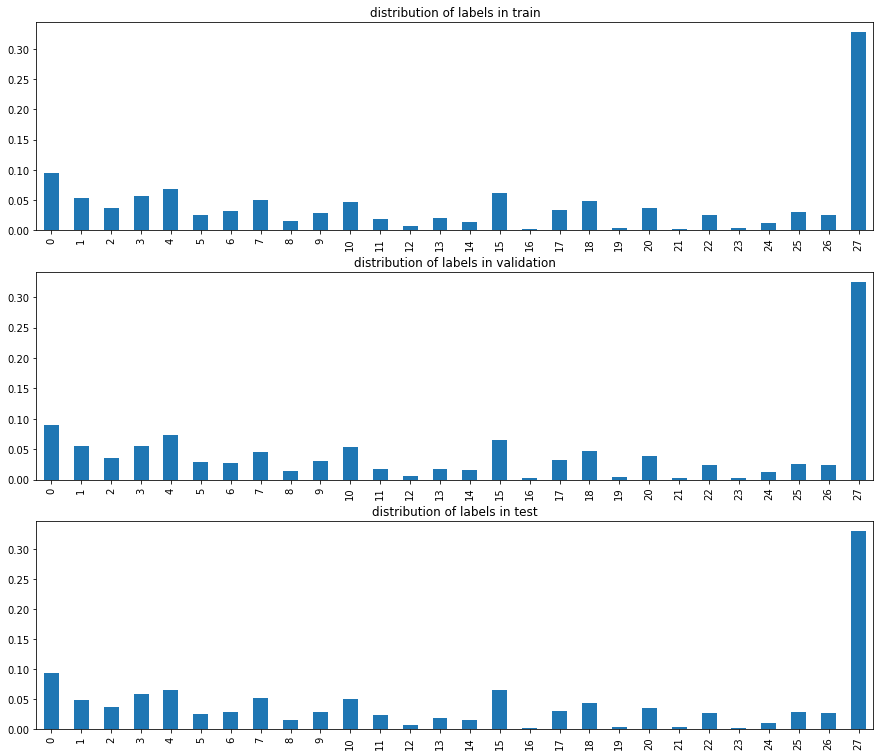

In [14]:
fig = plt.figure(figsize=(15, 13))

ax1 = plt.subplot(3, 1, 1)
train[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax1, title="distribution of labels in train")

ax2 = plt.subplot(3, 1, 2)
valid[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax2, title="distribution of labels in validation")

ax3 = plt.subplot(3, 1, 3)
test[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax3, title="distribution of labels in test")

In [40]:
def show_sample_data(label, n=5):
    samples = train[train[label] == 1].sample(5)
    sentiment = mapping[label]
    
    print(f"Sample of emotion {sentiment}: ")
    print()
    for text in samples["text"]:
        print(text)
        print("---")

## Admiration sample

In [41]:
show_sample_data(0)

Sample of emotion admiration: 

Hey congrats man, you passed your limits, now keep on going Tekken only gets more fun the better you get
---
I get my tax money back every year, no complaints. Plus the college and other skills i got were worth it.
---
I’m a millennial and my mortgage payment only takes about 1/5 of my after tax earnings in a month. Feels so good.
---
Hey congrats!! That's amazing, you've done such amazing progress! Hope you have a great day :)
---
She even tweeted the Ghost Adventures crew, oh wow. 
---


## Amusement sample

In [42]:
show_sample_data(1)

Sample of emotion amusement: 

“She had the same expression as the shocked Pikachu meme.” Lmao.. this made me laugh so hard lol
---
Haha! [NAME] aside, that is *wonderful*!
---
Lmao, I really messed this up. Loved your replies in the og thread, mate, keep up the good work :). 
---
You're allowed to me a little mean here, no one will tell lol
---
A hug? Lol, shugos new hugs look alot more fluid and faster. Get ready to eat more
---


## Anger sample

In [43]:
show_sample_data(2)

Sample of emotion anger: 

“I’ll never have a playoff mandate” go fuck yourself [NAME]
---
shut up LIBTARD you right now:🤯😭🥺
---
Ok. Hang onto shit you can't change and be whiney about it. This is a reason why we catch shit. We can't take it
---
"Oh, how DARE you discuss the disgustingly unhealthy and dangerous lifestyle I pursue!" /s
---
Dude I have a verrrrry strong feeling the barber did that on purpose. Nowhere in the world is that an acceptable haircut. That’s fucked up
---


## Caring sample

In [44]:
show_sample_data(5)

Sample of emotion caring: 

Hi, don’t feel alone. Im here to talk if ya want if not thats cool too. Remember to try to be optimistic!
---
Live your life well. Let them figure it out for themselves.
---
It will be painful but it will be worth it! Good Luck, and may you never be a slave to a drug again !
---
I want him to change and realize he messed up and he needs to do better
---
Definitely don’t rush. That’s how unfortunate decisions happen, and then you’re linked to that person for the rest of your life.
---


#**Dataset Definition**

In [20]:
class GoEmotionDataset():
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets
        self.tokenizer = transformers.SqueezeBertTokenizer.from_pretrained(
            "squeezebert/squeezebert-uncased", do_lower_case=True
        )
        self.max_len = 35
        
    def __len__(self):
        return len(self.texts)

    
    def __getitem__(self, index):
        target = self.targets[index]
        text = self.texts[index]
        
        inputs = self.tokenizer.encode_plus(text,
                                            None,
                                            add_special_tokens=True,
                                            max_length=self.max_len,
                                            padding="max_length",
                                            truncation=True)
        
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }

# **Emotion Classifier Model Definition**

The **Emotion Classifier Class** inherit **Tez Model** and implement its function 


In [21]:
from tez import TezConfig

class EmotionClassifier(tez.Model):
    def __init__(self, num_train_steps, num_classes):
        super().__init__()
        self.bert = transformers.SqueezeBertModel.from_pretrained("squeezebert/squeezebert-uncased")
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, num_classes)
        self.num_train_steps = num_train_steps
        self.step_scheduler_after = "batch"
        self.config = TezConfig(
            fp16=True,
            val_strategy="batch",
            val_steps=100
        )
    
    def fetch_optimizer(self):
        param_optimizer = list(self.named_parameters())
        no_decay = ["bias", "LayerNorm.bias"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        opt = AdamW(optimizer_parameters, lr=3e-5)
        return opt

    
    def fetch_scheduler(self):
        sch = get_linear_schedule_with_warmup(
            self.optimizer, num_warmup_steps=0, num_training_steps=self.num_train_steps
        )
        return sch
    
    def loss(self, outputs, targets):
        if targets is None:
            return None
        return nn.BCEWithLogitsLoss()(outputs, targets.float())
    
    
    def monitor_metrics(self, outputs, targets):
        if targets is None:
            return {}
        
        outputs = torch.sigmoid(outputs)
        outputs = outputs.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        
        fpr_micro, tpr_micro, _ = metrics.roc_curve(targets.ravel(), outputs.ravel())
        auc_micro = metrics.auc(fpr_micro, tpr_micro)
        return {"auc": auc_micro}
 
    
    def forward(self, ids, mask, targets=None):
        o_2 = self.bert(ids, attention_mask=mask)["pooler_output"]
        b_o = self.bert_drop(o_2)
        output = self.out(b_o)
        loss = self.loss(output, targets)
        acc = self.monitor_metrics(output, targets)
        return output, loss, acc

# **Start the training**

In [22]:
train_dataset = GoEmotionDataset(train.text.tolist(), train[range(n_labels)].values.tolist())
valid_dataset = GoEmotionDataset(valid.text.tolist(), valid[range(n_labels)].values.tolist())

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/500 [00:00<?, ?B/s]

In [23]:
from pytorch_lightning import loggers as logger

n_train_steps = int(len(train) / 32 * 10)
model = EmotionClassifier(n_train_steps, n_labels)

es = tez.callbacks.EarlyStopping(monitor="valid_loss", model_path="model.bin")

model.fit(train_dataset,
          valid_dataset, 
          train_bs=64,
          device="cuda", 
          callbacks=[es], 
          epochs=8, 
          fp16=True,
          n_jobs=10)

Downloading:   0%|          | 0.00/103M [00:00<?, ?B/s]

Some weights of the model checkpoint at squeezebert/squeezebert-uncased were not used when initializing SqueezeBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing SqueezeBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SqueezeBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NOTE: This is old Model class and is deprecated. It will no longer be maintained! Please use version > 0.5.1. Its much better and supports multi-gpu training too!


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
100%|██████████| 340/340 [00:13<00:00, 25.59it/s, auc=0.949, loss=0.0894, stage=valid]


In [24]:
model.load("drive/MyDrive/model.bin")

In [25]:
test_dataset = GoEmotionDataset(test.text.tolist(), test[range(n_labels)].values.tolist())
dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)

# **Test Set Evaluation**

In [26]:
outputs = []

with torch.no_grad():
    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        output, loss, acc = model.forward(batch["ids"].to("cuda"), 
                                          batch["mask"].to("cuda"), 
                                          #batch["token_type_ids"].to("cuda"),
                                          batch["targets"].to("cuda")
                                         )
        outputs.append(output)

  0%|          | 0/85 [00:00<?, ?it/s]

In [27]:
outputs = torch.cat(outputs)
outputs = torch.sigmoid(outputs)
outputs = outputs.cpu().detach().numpy()

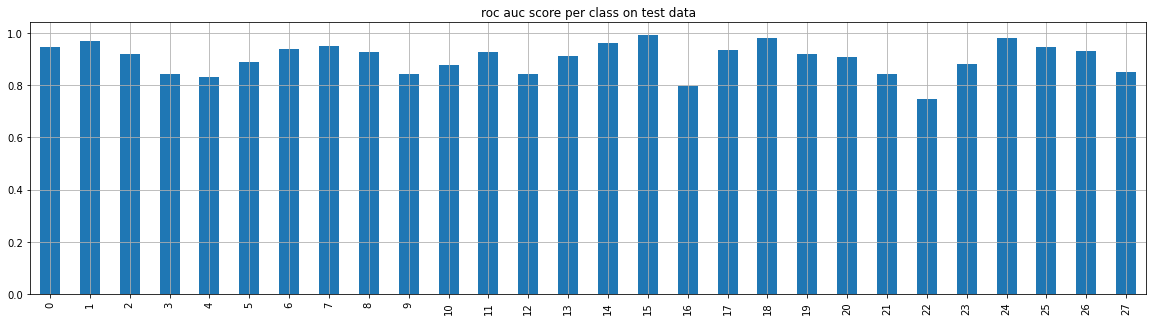

In [28]:
roc_metrics = []

for i in range(n_labels):
    roc = metrics.roc_auc_score(test[i].values, outputs[:, i])
    roc_metrics.append(roc)

s = pd.Series(roc_metrics, index=range(n_labels))

s.plot(kind="bar", figsize=(20, 5), title="roc auc score per class on test data", grid=True)

In [29]:
tokenizer = transformers.SqueezeBertTokenizer.from_pretrained(
            "squeezebert/squeezebert-uncased", do_lower_case=True
        )

In [50]:
def pred_sentence_emotions(text, topn=5):
    max_len = 35
    with torch.no_grad():

        inputs = tokenizer.encode_plus(text,
                                       None,
                                       add_special_tokens=True,
                                       max_length=max_len,
                                       padding="max_length",
                                       truncation=True)
        ids = inputs["input_ids"]
        ids = torch.LongTensor(ids).cuda().unsqueeze(0)

        attention_mask = inputs["attention_mask"]
        attention_mask = torch.LongTensor(attention_mask).cuda().unsqueeze(0)

        output = model.forward(ids, attention_mask)[0]
        output = torch.sigmoid(output)

        probas, indices = torch.sort(output)

    probas = probas.cpu().numpy()[0][::-1]
    indices = indices.cpu().numpy()[0][::-1]

    for i, p in zip(indices[:topn], probas[:topn]):
        print(mapping[i]," --> ", p)

In [97]:
def get_emotions(text, topn=28):
    max_len = 35
    with torch.no_grad():

        inputs = tokenizer.encode_plus(text,
                                       None,
                                       add_special_tokens=True,
                                       max_length=max_len,
                                       padding="max_length",
                                       truncation=True)
        ids = inputs["input_ids"]
        ids = torch.LongTensor(ids).cuda().unsqueeze(0)

        attention_mask = inputs["attention_mask"]
        attention_mask = torch.LongTensor(attention_mask).cuda().unsqueeze(0)

        output = model.forward(ids, attention_mask)[0]
        output = torch.sigmoid(output)

        probas, indices = torch.sort(output)
    probas = probas.cpu().numpy()[0][::-1]

    return probas

In [98]:
labels = _CLASS_NAMES

preds = np.zeros((len(test), len(labels)))

for i, j in enumerate(preds):
    preds[i] = get_emotions(test['text'][i])

In [103]:
result = pd.concat([test["text"], pd.DataFrame(preds, columns = labels)], axis=1)
result.to_csv('result.csv', index=False)
result.head(20)

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,"I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!",0.526056,0.373152,0.244303,0.029469,0.028935,0.024832,0.024084,0.023810,0.022156,...,0.012763,0.010677,0.009959,0.009732,0.008390,0.008281,0.007924,0.006260,0.004994,0.004698
1,It's wonderful because it's awful. At not with.,0.620540,0.327627,0.078902,0.069269,0.054358,0.049840,0.049821,0.047373,0.035413,...,0.012294,0.011280,0.011093,0.009118,0.008941,0.006570,0.005852,0.005229,0.004617,0.002927
2,"Kings fan here, good luck to you guys! Will be an interesting game to watch!",0.578316,0.189364,0.160826,0.148041,0.134041,0.062712,0.052814,0.031691,0.028556,...,0.004555,0.003257,0.003195,0.003022,0.002715,0.002695,0.002316,0.001776,0.001754,0.001151
3,"I didn't know that, thank you for teaching me something today!",0.965120,0.016103,0.015131,0.014346,0.014229,0.013478,0.009953,0.008929,0.008095,...,0.002348,0.002326,0.002249,0.002114,0.001877,0.001828,0.001738,0.001149,0.001127,0.000949
4,They got bored from haunting earth for thousands of years and ultimately moved on to the afterlife.,0.597700,0.124403,0.103793,0.096478,0.038438,0.028578,0.022486,0.018083,0.015314,...,0.003728,0.003686,0.003312,0.003042,0.002809,0.002744,0.002380,0.002293,0.001059,0.000348
5,Thank you for asking questions and recognizing that there may be things that you don’t know or understand about police tactics. Seriously. Thank you.,0.969093,0.018121,0.014848,0.011984,0.011054,0.007981,0.007193,0.006715,0.006585,...,0.002745,0.002539,0.002316,0.001858,0.001720,0.001634,0.001543,0.000988,0.000964,0.000758
6,You’re welcome,0.952975,0.037510,0.028172,0.016630,0.011877,0.009724,0.008439,0.006178,0.004804,...,0.002140,0.002106,0.001547,0.001512,0.001491,0.001270,0.001235,0.001176,0.000963,0.000829
7,100%! Congrats on your job too!,0.666062,0.658512,0.055338,0.027062,0.016983,0.016766,0.014946,0.011234,0.010353,...,0.003512,0.003492,0.002875,0.002857,0.002845,0.002130,0.002091,0.001926,0.001168,0.001110
8,I’m sorry to hear that friend :(. It’s for the best most likely if she didn’t accept you for who you are,0.609708,0.254237,0.058373,0.034219,0.033559,0.028175,0.023498,0.020754,0.020600,...,0.011553,0.010754,0.008108,0.007830,0.007010,0.006324,0.005648,0.004817,0.004522,0.004320
9,"Girlfriend weak as well, that jump was pathetic.",0.478945,0.327747,0.092205,0.073679,0.062372,0.062154,0.032870,0.030689,0.019835,...,0.005258,0.004985,0.004840,0.004266,0.003745,0.003565,0.003373,0.002276,0.001925,0.000897


# **Test some sentences**

In [51]:
pred_sentence_emotions("i miss my brother")

sadness  -->  0.8133339
disappointment  -->  0.20982283
neutral  -->  0.088860735
remorse  -->  0.054530498
love  -->  0.04272086


In [52]:
pred_sentence_emotions("funny how this craps out!")

amusement  -->  0.9165136
joy  -->  0.117156945
admiration  -->  0.02651815
neutral  -->  0.019300831
excitement  -->  0.014220701


In [53]:
pred_sentence_emotions("i hope you go to hell! ")

optimism  -->  0.8319009
caring  -->  0.06633774
desire  -->  0.040979486
neutral  -->  0.03496978
admiration  -->  0.0313627


In [54]:
pred_sentence_emotions("you might have a point, but i strongly disagree with you")

disapproval  -->  0.68897057
approval  -->  0.10372091
neutral  -->  0.10024414
annoyance  -->  0.088920444
disappointment  -->  0.039644837


In [55]:
pred_sentence_emotions("i'm feeling very confident with this solution")

optimism  -->  0.5661624
approval  -->  0.23370177
admiration  -->  0.21523917
caring  -->  0.07948825
neutral  -->  0.05954335


In [59]:
pred_sentence_emotions("try to be more careful my friend")

caring  -->  0.69222414
neutral  -->  0.09463137
approval  -->  0.057007153
optimism  -->  0.05148783
fear  -->  0.039568253
